In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
boxes = [100,88,253,209]
img = mpimg.imread('bPawn0.jpg')

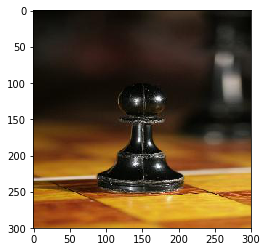

In [3]:
plt.imshow(img.reshape(300,300,3))
plt.show()

In [4]:
box = np.ones([1,1,4])

In [5]:
for i in range(4):
    box[:,:,i] = boxes[i]/300

In [6]:
img = img.reshape(1,300,300,3)

In [7]:
img = tf.convert_to_tensor(img, np.float32)

In [8]:
box = tf.convert_to_tensor(box, np.float32)

In [9]:
test = tf.image.draw_bounding_boxes(img, box)

In [10]:
sess = tf.Session()

In [11]:
test2 = sess.run(test)

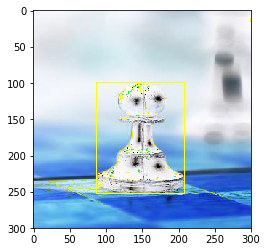

In [12]:
plt.imshow(test2.reshape(300,300,3))
plt.show()

In [13]:
size = [1,300,300,3]
size = tf.convert_to_tensor(size, np.int32)

In [14]:
begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(tf.shape(img),bounding_boxes=box)


ValueError: Tried to convert 'min_object_covered' to a tensor and failed. Error: None values not supported.

In [15]:
begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(size,bounding_boxes=box)


ValueError: Tried to convert 'min_object_covered' to a tensor and failed. Error: None values not supported.